In [12]:
import pandas as pd
import numpy as np
import cv2

In [3]:
from google.colab import files
files.upload()

Saving YE358311_Fender_apron.zip to YE358311_Fender_apron.zip


In [13]:
!pwd

/content


In [14]:
import zipfile
with zipfile.ZipFile("YE358311_Fender_apron.zip","r") as zip_ref:
    zip_ref.extractall("/content/data")

In [15]:
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [16]:
def pre_processing(image_path):
  image = cv2.imread(image_path)
  image = np.array(image,dtype = np.uint8)
  if image.shape[1] < image.shape[0]:
    image = np.rot90(image) #Rotating Image if it is vertical
  gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(image, (13,13) ,0) #To Reduce Noise in image
  return gray, blur, image

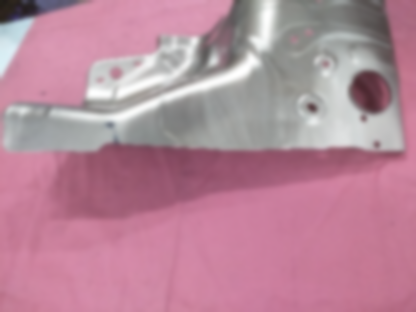

In [17]:
image_path = '/content/data/defected_images/OutputIMG20180905144839.jpg'
gray , blur, image = pre_processing(image_path)
Image.fromarray(blur)

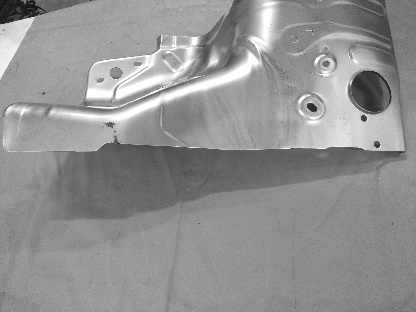

In [18]:
Image.fromarray(gray)

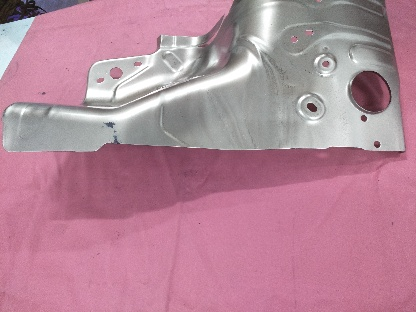

In [19]:
Image.fromarray(image)

In [20]:
from skimage.exposure import rescale_intensity
def convolve(image, kernel):
    (iH,iW)=image.shape[:2]
    (kH,kW)=kernel.shape[:2]
    pad=(kW-1)/2
    pad=int(pad)
    image=cv2.copyMakeBorder(image,pad,pad,pad,pad,cv2.BORDER_REPLICATE)
    output=np.zeros((iH,iW),dtype="float32")

    for y in np.arange(pad,iH+pad):
        for x in np.arange(pad,iW+pad):
            roi=image[y-pad:y+pad+1,x-pad:x+pad+1]
            k=(roi*kernel).sum()
            output[y-pad,x-pad]=k
    output=rescale_intensity(output,in_range=(0,255))
    output=(output*255).astype("uint8")
    return output

In [21]:
def run_kerneler(image):
    #Sharpening Kernels
    sharpen=np.array((
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]),dtype="int")

    #Laplacian Kerner
    laplacian=np.array((
    [0,1,0],
    [1,-4,1],
    [0,1,0]),dtype="int")

    #Sobel Kernel in the X direction, detects the edges only in the X direction
    sobelX=np.array((
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]),dtype="int")

    #Sobel Kernel in the Y direction, detects the edges only in the Y direction
    sobelY=np.array((
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]),dtype="int")

    #Kernel bank, sends the image and the kernel to convolve function, to convolute it
    kernelBank=(
    #("Small Blurring",smallBlur),
    #("Large Blurring",largeBlur),
    ("Sharpen",sharpen),
    ("Sobel X",sobelX),
    ("Sobel Y",sobelY),
    ("Laplacian",laplacian))
    #Adding first image here
    gray, blur, image = pre_processing(image)
    #Converting image to gray-scale here
    #Displaying images here
    #Cycles through all the kernels available in the bank, compares with the image
    for(kernelName,kernel) in kernelBank:
        print("[INFO]Applying {} kernel".format(kernelName))
        convolve_gray_Output=convolve(gray,kernel)
        convolve_blur_Output=convolve(blur,kernel)
        convolve_gray_Output=cv2.copyMakeBorder(convolve_gray_Output,0,50,0,0,cv2.BORDER_CONSTANT,value=[255,0,0])
        convolve_gray_Output=cv2.putText(convolve_gray_Output,"Filter: "+kernelName+" "+"Mode: Gray",(10,(convolve_gray_Output.shape[0]-20)),cv2.FONT_HERSHEY_SIMPLEX,0.35, (100,100,100),1,cv2.LINE_AA)
        convolve_gray_Output=cv2.rectangle(convolve_gray_Output,(0,(convolve_gray_Output.shape[0]-50)),(convolve_gray_Output.shape[1],convolve_gray_Output.shape[0]),(0,0,0),3)
        convolve_blur_Output=cv2.copyMakeBorder(convolve_blur_Output,0,50,0,0,cv2.BORDER_CONSTANT,value=[255,0,0])
        convolve_blur_Output=cv2.putText(convolve_blur_Output,"Filter: "+kernelName+" "+"Mode: Blur",(10,(convolve_blur_Output.shape[0]-20)),cv2.FONT_HERSHEY_SIMPLEX,0.35, (100,100,100),1,cv2.LINE_AA)
        convolve_blur_Output=cv2.rectangle(convolve_blur_Output,(0,(convolve_blur_Output.shape[0]-50)),(convolve_blur_Output.shape[1],convolve_blur_Output.shape[0]),(0,0,0),3)
        cv2.imwrite('Results/'+kernelName+"_Gray"+".jpg", convolve_gray_Output)
        cv2.imwrite('Results/'+kernelName+"_Blur"+".jpg", convolve_blur_Output)

In [22]:
run_kerneler("/content/data/defected_images/OutputIMG20180905144839.jpg")

[INFO]Applying Sharpen kernel
[INFO]Applying Sobel X kernel
[INFO]Applying Sobel Y kernel
[INFO]Applying Laplacian kernel


In [23]:
import os
import random
train_dir_1 = '/content/data/defected_images'
train_dir_2 = '/content/data/healthy_images'
test_dir = '/content/data/test'
train_defective = ["/content/data/defected_images/{}".format(i) for i in os.listdir(train_dir_1)]
train_healthy = ["/content/data/healthy_images/{}".format(i) for i in os.listdir(train_dir_2)]
print('Healthy Images: {}'.format(len(train_healthy)))
print("Defected Images: {}".format(len(train_defective)))


Healthy Images: 126
Defected Images: 97


In [24]:
x = []
y = []
nrows = 224
ncolumns =224
channels =3
for image in train_defective:
  #print(image)
  x.append(cv2.resize(pre_processing(image)[2], (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
  y.append(1)
for image in train_healthy:
  x.append(cv2.resize(pre_processing(image)[2] , (nrows,ncolumns) , interpolation = cv2.INTER_CUBIC))
  y.append(0)

In [25]:
train = list(zip(x,y))
random.shuffle(train)
x , y = zip(*train)
x = np.array(x)
y = np.array(y)
print("Shape of X is {}".format(x.shape))
print("Shape of Y is {}".format(y.shape))

Shape of X is (223, 224, 224, 3)
Shape of Y is (223,)


In [26]:
targets = y
y = np.eye(2)[targets]

In [27]:
#For Test Dataset
test_defected_directory = '/content/data/test/defected'
test_healthy_directory = '/content/data/test/healthy'
test_defective = ['/content/data/test/defected/{}'.format(i) for i in os.listdir(test_defected_directory)]
test_healthy = ['/content/data/test/healthy/{}'.format(i) for i in os.listdir(test_healthy_directory)]
xtest = []
ytest = []
for image in test_defective:
  #print(image)
  xtest.append(cv2.resize(pre_processing(image)[2] , (nrows,ncolumns) , interpolation = cv2.INTER_CUBIC))
  ytest.append(1)
for image in test_healthy:
  xtest.append(cv2.resize(pre_processing(image)[2] , (nrows,ncolumns) , interpolation = cv2.INTER_CUBIC))
  ytest.append(0)
test = list(zip(xtest,ytest))
random.shuffle(test)
xtest , ytest = zip(*test)
xtest = np.array(xtest)
ytest = np.array(ytest)
print("Shape of xtest is {}".format(xtest.shape))
print("Shape of ytest is {}".format(ytest.shape))
targets = ytest
ytest = np.eye(2)[targets]
print('Length of Test Data is {}'.format(len(ytest)))

Shape of xtest is (20, 224, 224, 3)
Shape of ytest is (20,)
Length of Test Data is 20


In [28]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 2
conv_size = 32

# parameters for training
batch_size = 16
num_epochs = 20

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers
x1 = InceptionV3_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(512, activation="relu")(x1)
Custom_Output = Dense(num_classes, activation='softmax')(x1)

# define the input and output of the model
InceptionV3_model = Model(inputs = InceptionV3_model.input, outputs = Custom_Output)
        
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

# compile the model
InceptionV3_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

InceptionV3_model.summary()

Using TensorFlow backend.


87916544/87910968 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
___________________________

In [30]:
history = InceptionV3_model.fit(x, y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 178 samples, validate on 45 samples
Epoch 1/20
178/178 [==============================] - 3s 16ms/step - loss: 0.4888 - accuracy: 0.7528 - val_loss: 549.3589 - val_accuracy: 0.3333
Epoch 2/20
178/178 [==============================] - 3s 15ms/step - loss: 0.4376 - accuracy: 0.7809 - val_loss: 76.5703 - val_accuracy: 0.6667
Epoch 3/20
178/178 [==============================] - 3s 15ms/step - loss: 0.3527 - accuracy: 0.8202 - val_loss: 373.0216 - val_accuracy: 0.3333
Epoch 4/20
178/178 [==============================] - 3s 15ms/step - loss: 0.3379 - accuracy: 0.8539 - val_loss: 366.4360 - val_accuracy: 0.3333
Epoch 5/20
178/178 [==============================] - 3s 15ms/step - loss: 0.2031 - accuracy: 0.9213 - val_loss: 180.0889 - val_accuracy: 0.3333
Epoch 6/20
178/178 [==============================] - 3s 15ms/step - loss: 0.1844 - accuracy: 0.9494 - val_loss: 7264.2573 - val_accuracy: 0.3333
Epoch 7/20
178/178 [==============================] - 3s 15ms/step - loss: 0.2191 - a

In [33]:
ypred = InceptionV3_model.predict(xtest)
print(ypred)

[[9.5847088e-01 4.1529126e-02]
 [9.7409004e-01 2.5909970e-02]
 [9.9917078e-01 8.2926673e-04]
 [9.9999988e-01 7.6199875e-08]
 [9.9971479e-01 2.8516073e-04]
 [9.9782568e-01 2.1742708e-03]
 [9.8452944e-01 1.5470546e-02]
 [1.0000000e+00 3.2646389e-19]
 [6.7850268e-01 3.2149732e-01]
 [9.5668215e-01 4.3317873e-02]
 [9.9927324e-01 7.2672084e-04]
 [9.8805737e-01 1.1942611e-02]
 [6.9451511e-01 3.0548486e-01]
 [9.9407637e-01 5.9236633e-03]
 [9.9702269e-01 2.9772820e-03]
 [7.0644587e-01 2.9355413e-01]
 [9.6821219e-01 3.1787839e-02]
 [9.9773967e-01 2.2603765e-03]
 [9.9863029e-01 1.3696853e-03]
 [9.9981433e-01 1.8570232e-04]]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [37]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 2
conv_size = 32

# parameters for training
batch_size = 16
num_epochs = 20

# load MobileNet from Keras
MobileNet_model = MobileNet(include_top=False, input_shape=input_shape)

# add custom Layers
x2 = MobileNet_model.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(512, activation="relu")(x2)
Custom_Output = Dense(num_classes, activation='softmax')(x2)

# define the input and output of the model
MobileNet_model = Model(inputs = MobileNet_model.input, outputs = Custom_Output)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)   
# compile the model
MobileNet_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

MobileNet_model.summary()

17227776/17225924 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
____________________________________________________________

In [39]:
history = MobileNet_model.fit(x, y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Train on 200 samples, validate on 23 samples
Epoch 1/20
200/200 [==============================] - 9s 47ms/step - loss: 1.1985 - accuracy: 0.7000 - val_loss: 3.6978 - val_accuracy: 0.2609
Epoch 2/20
200/200 [==============================] - 2s 12ms/step - loss: 0.2995 - accuracy: 0.9000 - val_loss: 2.6724 - val_accuracy: 0.2609
Epoch 3/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0917 - accuracy: 0.9700 - val_loss: 0.8231 - val_accuracy: 0.6522
Epoch 4/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0681 - accuracy: 0.9750 - val_loss: 0.9569 - val_accuracy: 0.7391
Epoch 5/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0227 - accuracy: 0.9950 - val_loss: 0.1949 - val_accuracy: 0.9565
Epoch 6/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 0.1937 - val_accuracy: 0.9130
Epoch 7/20
200/200 [==============================] - 2s 12ms/step - loss: 0.0205 - accuracy: 0.9

In [40]:
y_mobilenet_pred = MobileNet_model.predict(xtest)
y_mobilenet_pred

array([[9.9049991e-01, 9.5000556e-03],
       [1.6665690e-04, 9.9983335e-01],
       [8.4554910e-04, 9.9915445e-01],
       [1.4844270e-05, 9.9998510e-01],
       [9.9999976e-01, 2.6415324e-07],
       [9.7751661e-05, 9.9990225e-01],
       [9.9999964e-01, 4.0408986e-07],
       [2.1833353e-05, 9.9997818e-01],
       [7.1125942e-05, 9.9992883e-01],
       [9.9999547e-01, 4.5687621e-06],
       [2.8315040e-01, 7.1684963e-01],
       [6.0321890e-06, 9.9999392e-01],
       [9.8886099e-03, 9.9011141e-01],
       [2.1408106e-01, 7.8591895e-01],
       [9.9901605e-01, 9.8389492e-04],
       [3.0463904e-01, 6.9536096e-01],
       [9.9991453e-01, 8.5506661e-05],
       [9.9999630e-01, 3.6793117e-06],
       [9.9781764e-01, 2.1824122e-03],
       [9.9997377e-01, 2.6263247e-05]], dtype=float32)

In [41]:
def make_classes(y_pred):
    for i in y_pred:
        if i[0] > 0.5:
            i[0]=1
            i[1]=0
        elif i[0] <= 0.5:
            i[1]=1
            i[0]=0
    return y_pred
  # Result : Here Class 1 is for defective image and Class 2 is for Healthy Image
make_classes(y_mobilenet_pred)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)